In [1]:
# tested with versions:
#  anndata: 0.9.1
#  h5py: 3.9.0
#  numpy: 1.17.0
#  pandas: 2.0.3
#  scanpy: 1.9.3
import numpy as np


import pandas as pd

# Tested with version 
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

h5_path = '/home/jorvis/git/gEAR/www/datasets/8df6216a-cc4e-f158-e7b0-fe425654b5a0.h5ad'

adata = sc.read_h5ad(h5_path)

## Pre-processing

### Show the genes which yield the highest fraction of counts in each cell, across the cells.

filtered out 2 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


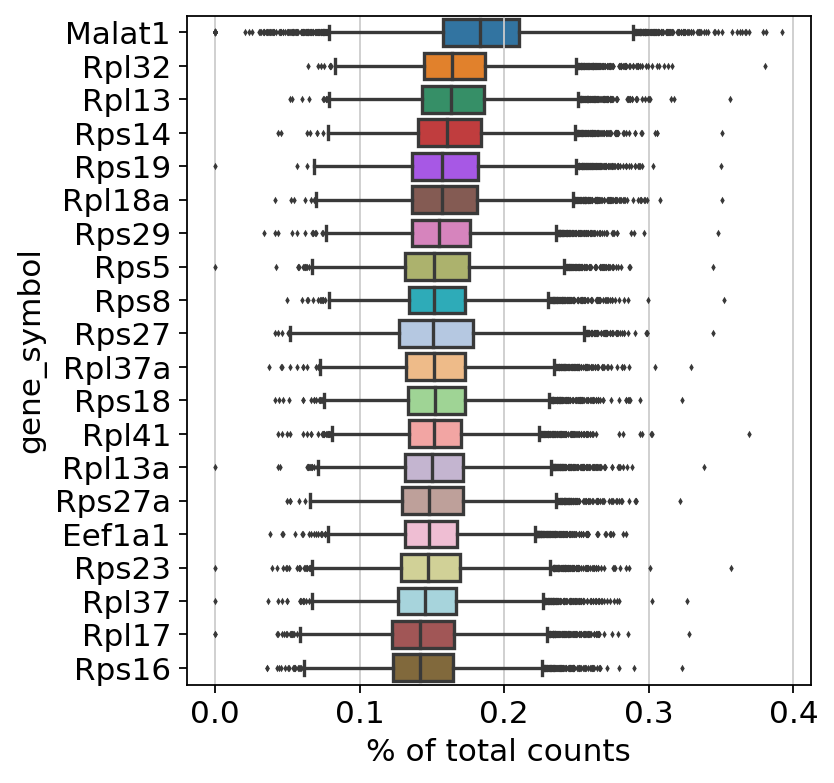

In [2]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_symbol', save=".png")

## Quality Control
### Violin plots of the computed quality measures (mitochondrial content)

/opt/Python-3.10.12/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


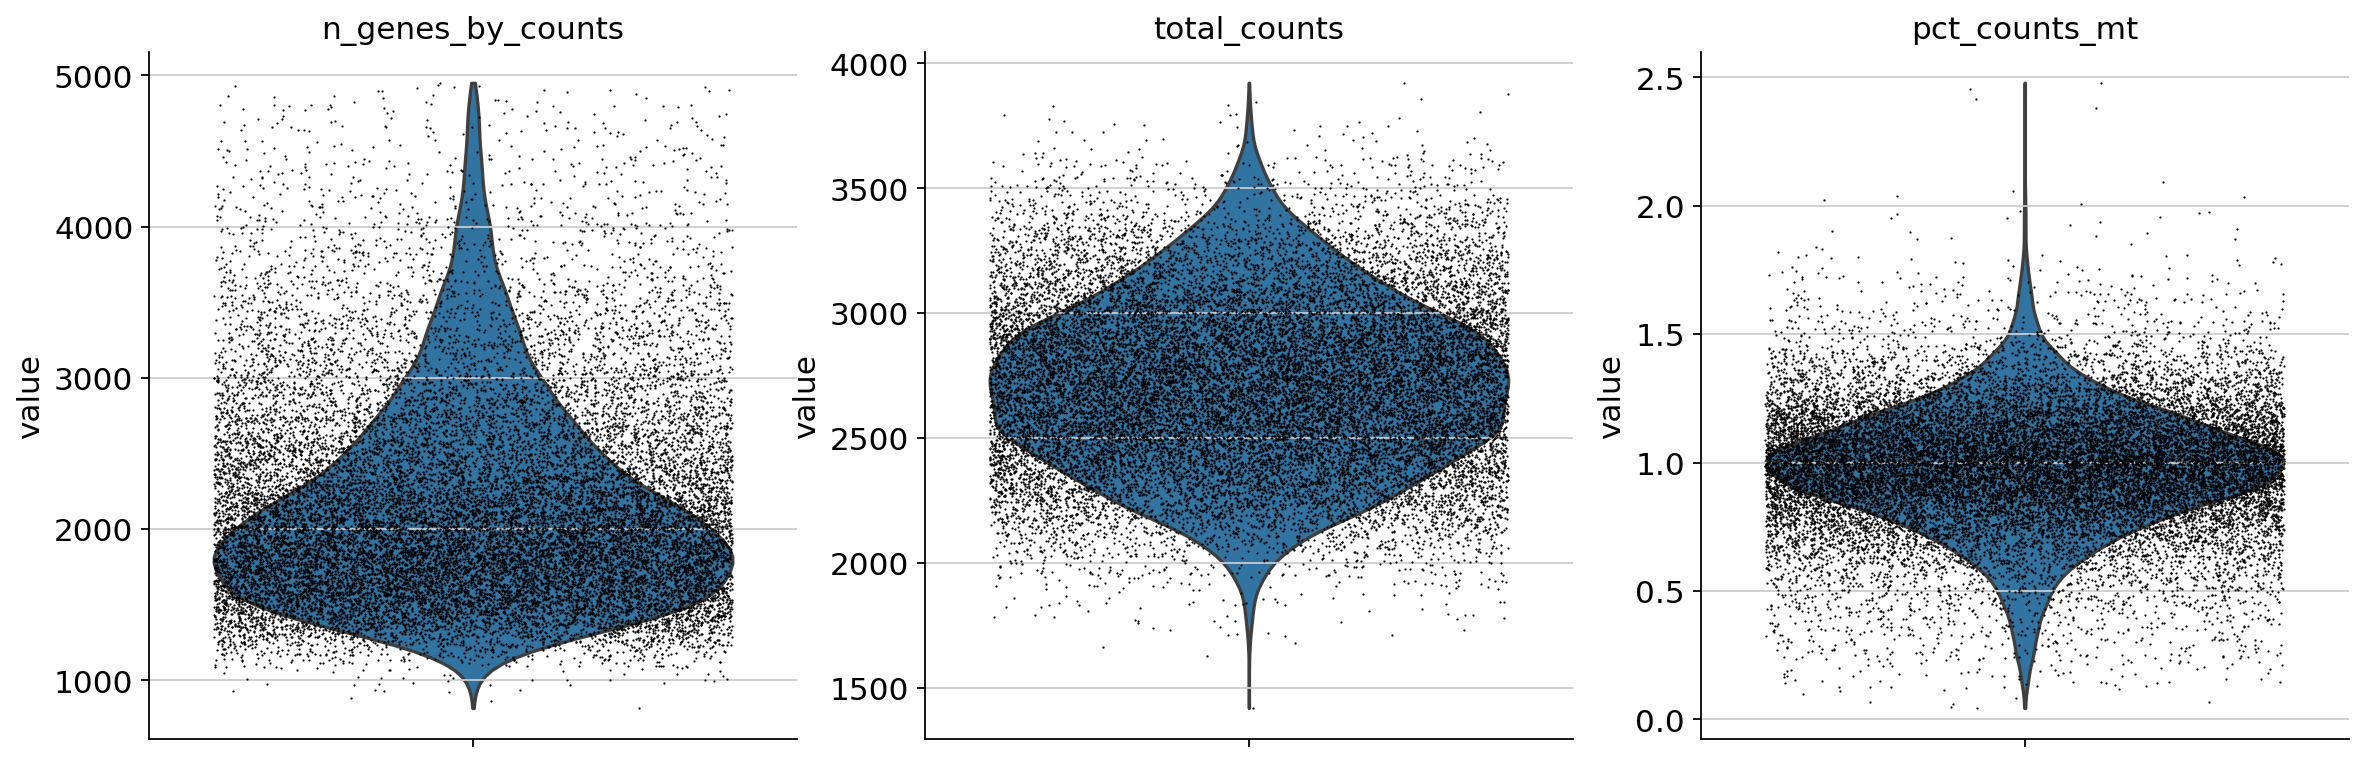

In [3]:
adata.var['mt'] = adata.var.gene_symbol.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Remove cells which have too many mitochrondrial genes expressed or too many total counts

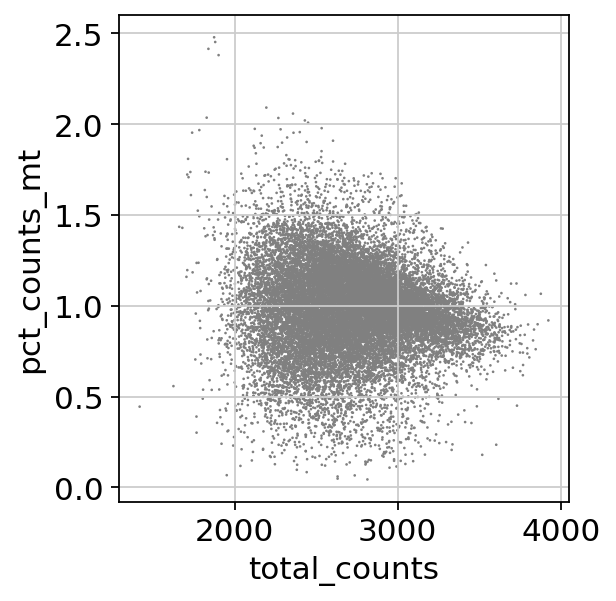

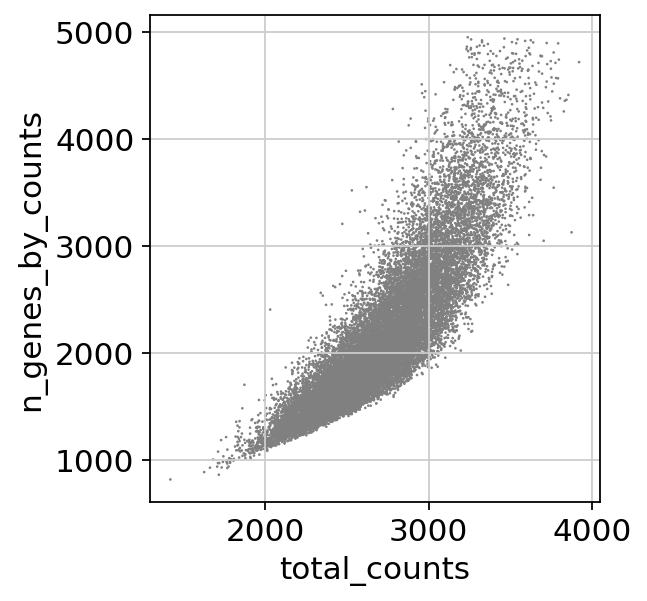

In [4]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Actually do the filtering by slicing the AnnData object

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

### Total-count normalize (library-size correct) the data matrix so that counts are comparable among cells

In [6]:
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.normalize_total(adata, target_sum=2000)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


### Identify and plot highly-variable genes

In [7]:
sc.pp.highly_variable_genes(
            adata, flavor="seurat", n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


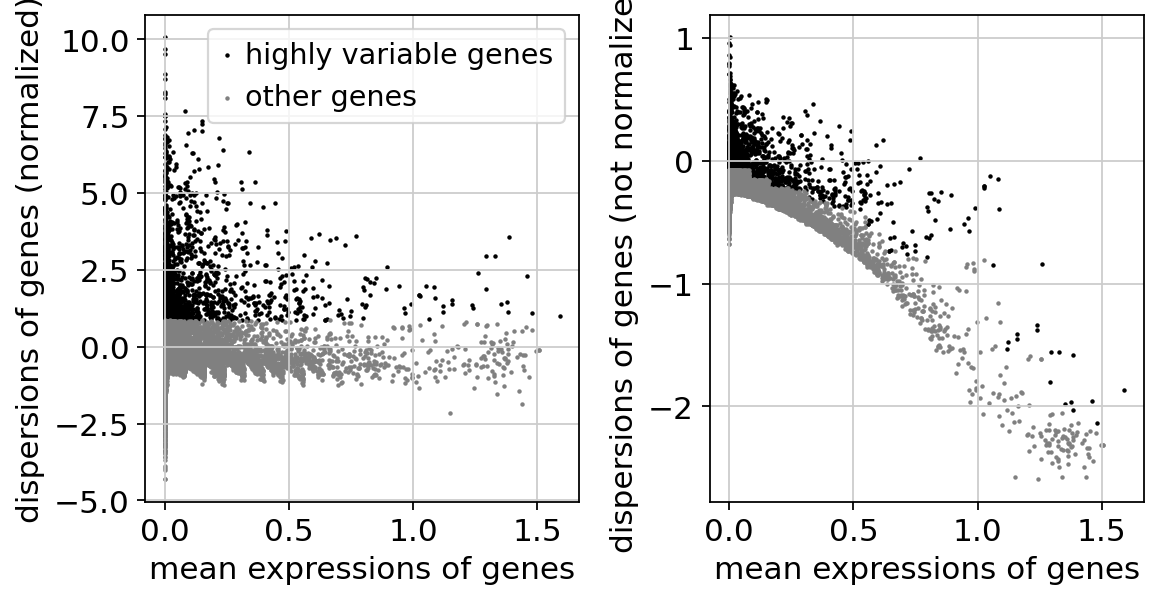

In [8]:
sc.pl.highly_variable_genes(adata)

### Actually do the filtering

In [9]:
adata = adata[:, adata.var.highly_variable]

### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [10]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:28)


### Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [11]:
sc.pp.scale(adata, max_value=10)

## Principle component analysis
### Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


### We can make a scatter plot in the PCA coordinates, but we will not use that later on.

/opt/Python-3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


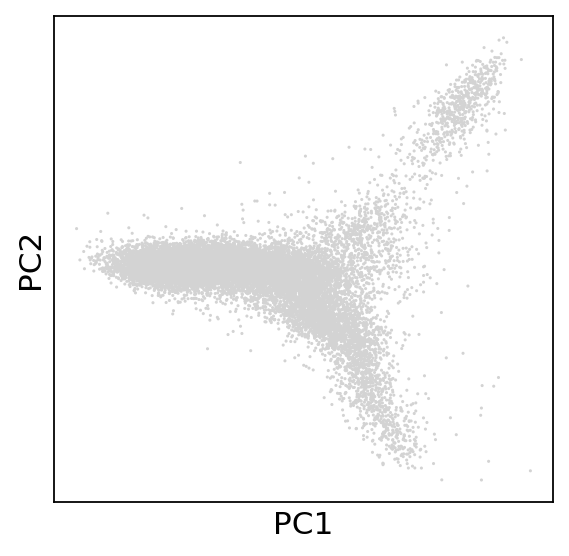

In [13]:
sc.pl.pca(adata)

### Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells

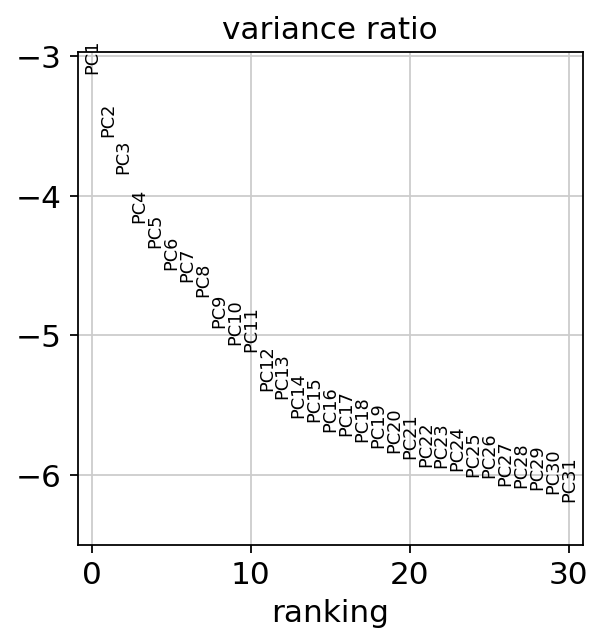

In [14]:
sc.pl.pca_variance_ratio(adata, log=True)

### compute the neighborhood graph

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=11)

computing neighbors
    using 'X_pca' with n_pcs = 11


/opt/Python-3.10.12/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/Python-3.10.12/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/Python-3.10.12/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)


In [17]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


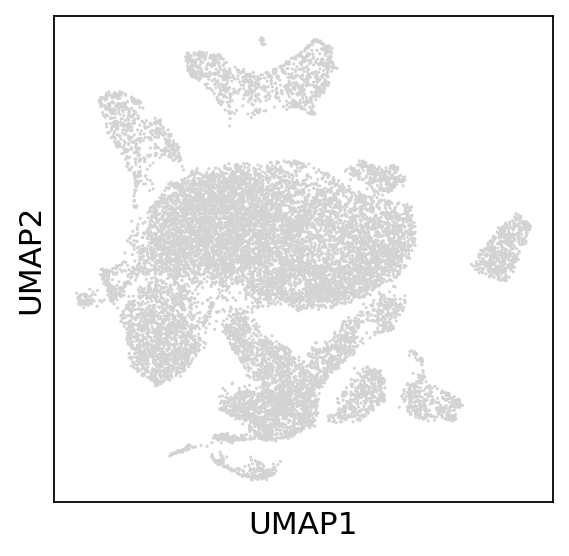

In [20]:
#sc.pl.umap(adata, color=['0610010F05Rik', '0610012G03Rik'])
sc.pl.umap(adata, use_raw=False)


### clustering the neighborhood graph

In [24]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


/opt/Python-3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


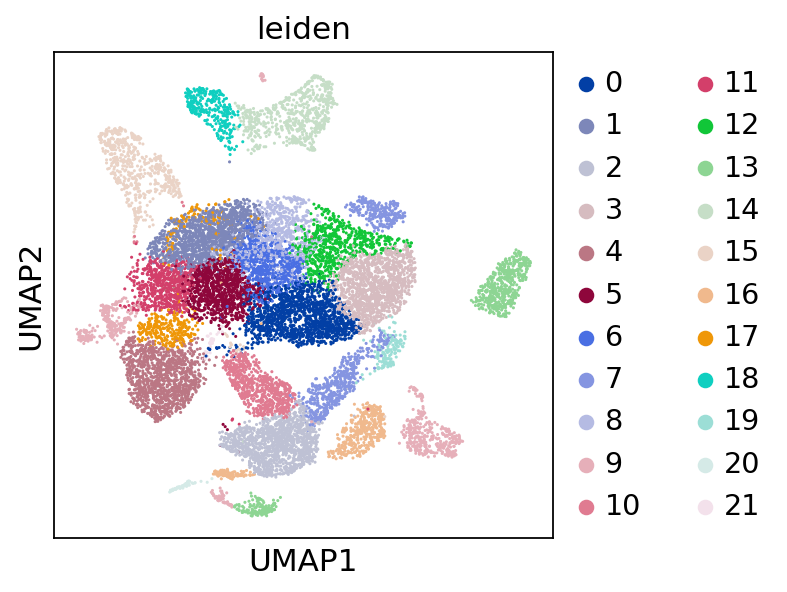

In [31]:
#sc.pl.umap(adata, color=['leiden', 'Fxyd3', 'Tubb3'])
sc.pl.umap(adata, color=['leiden'])


## Finding marker genes

### Compute a ranking for the highly differential genes in each cluster

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


/opt/Python-3.10.12/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/Python-3.10.12/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/Python-3.10.12/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented. 

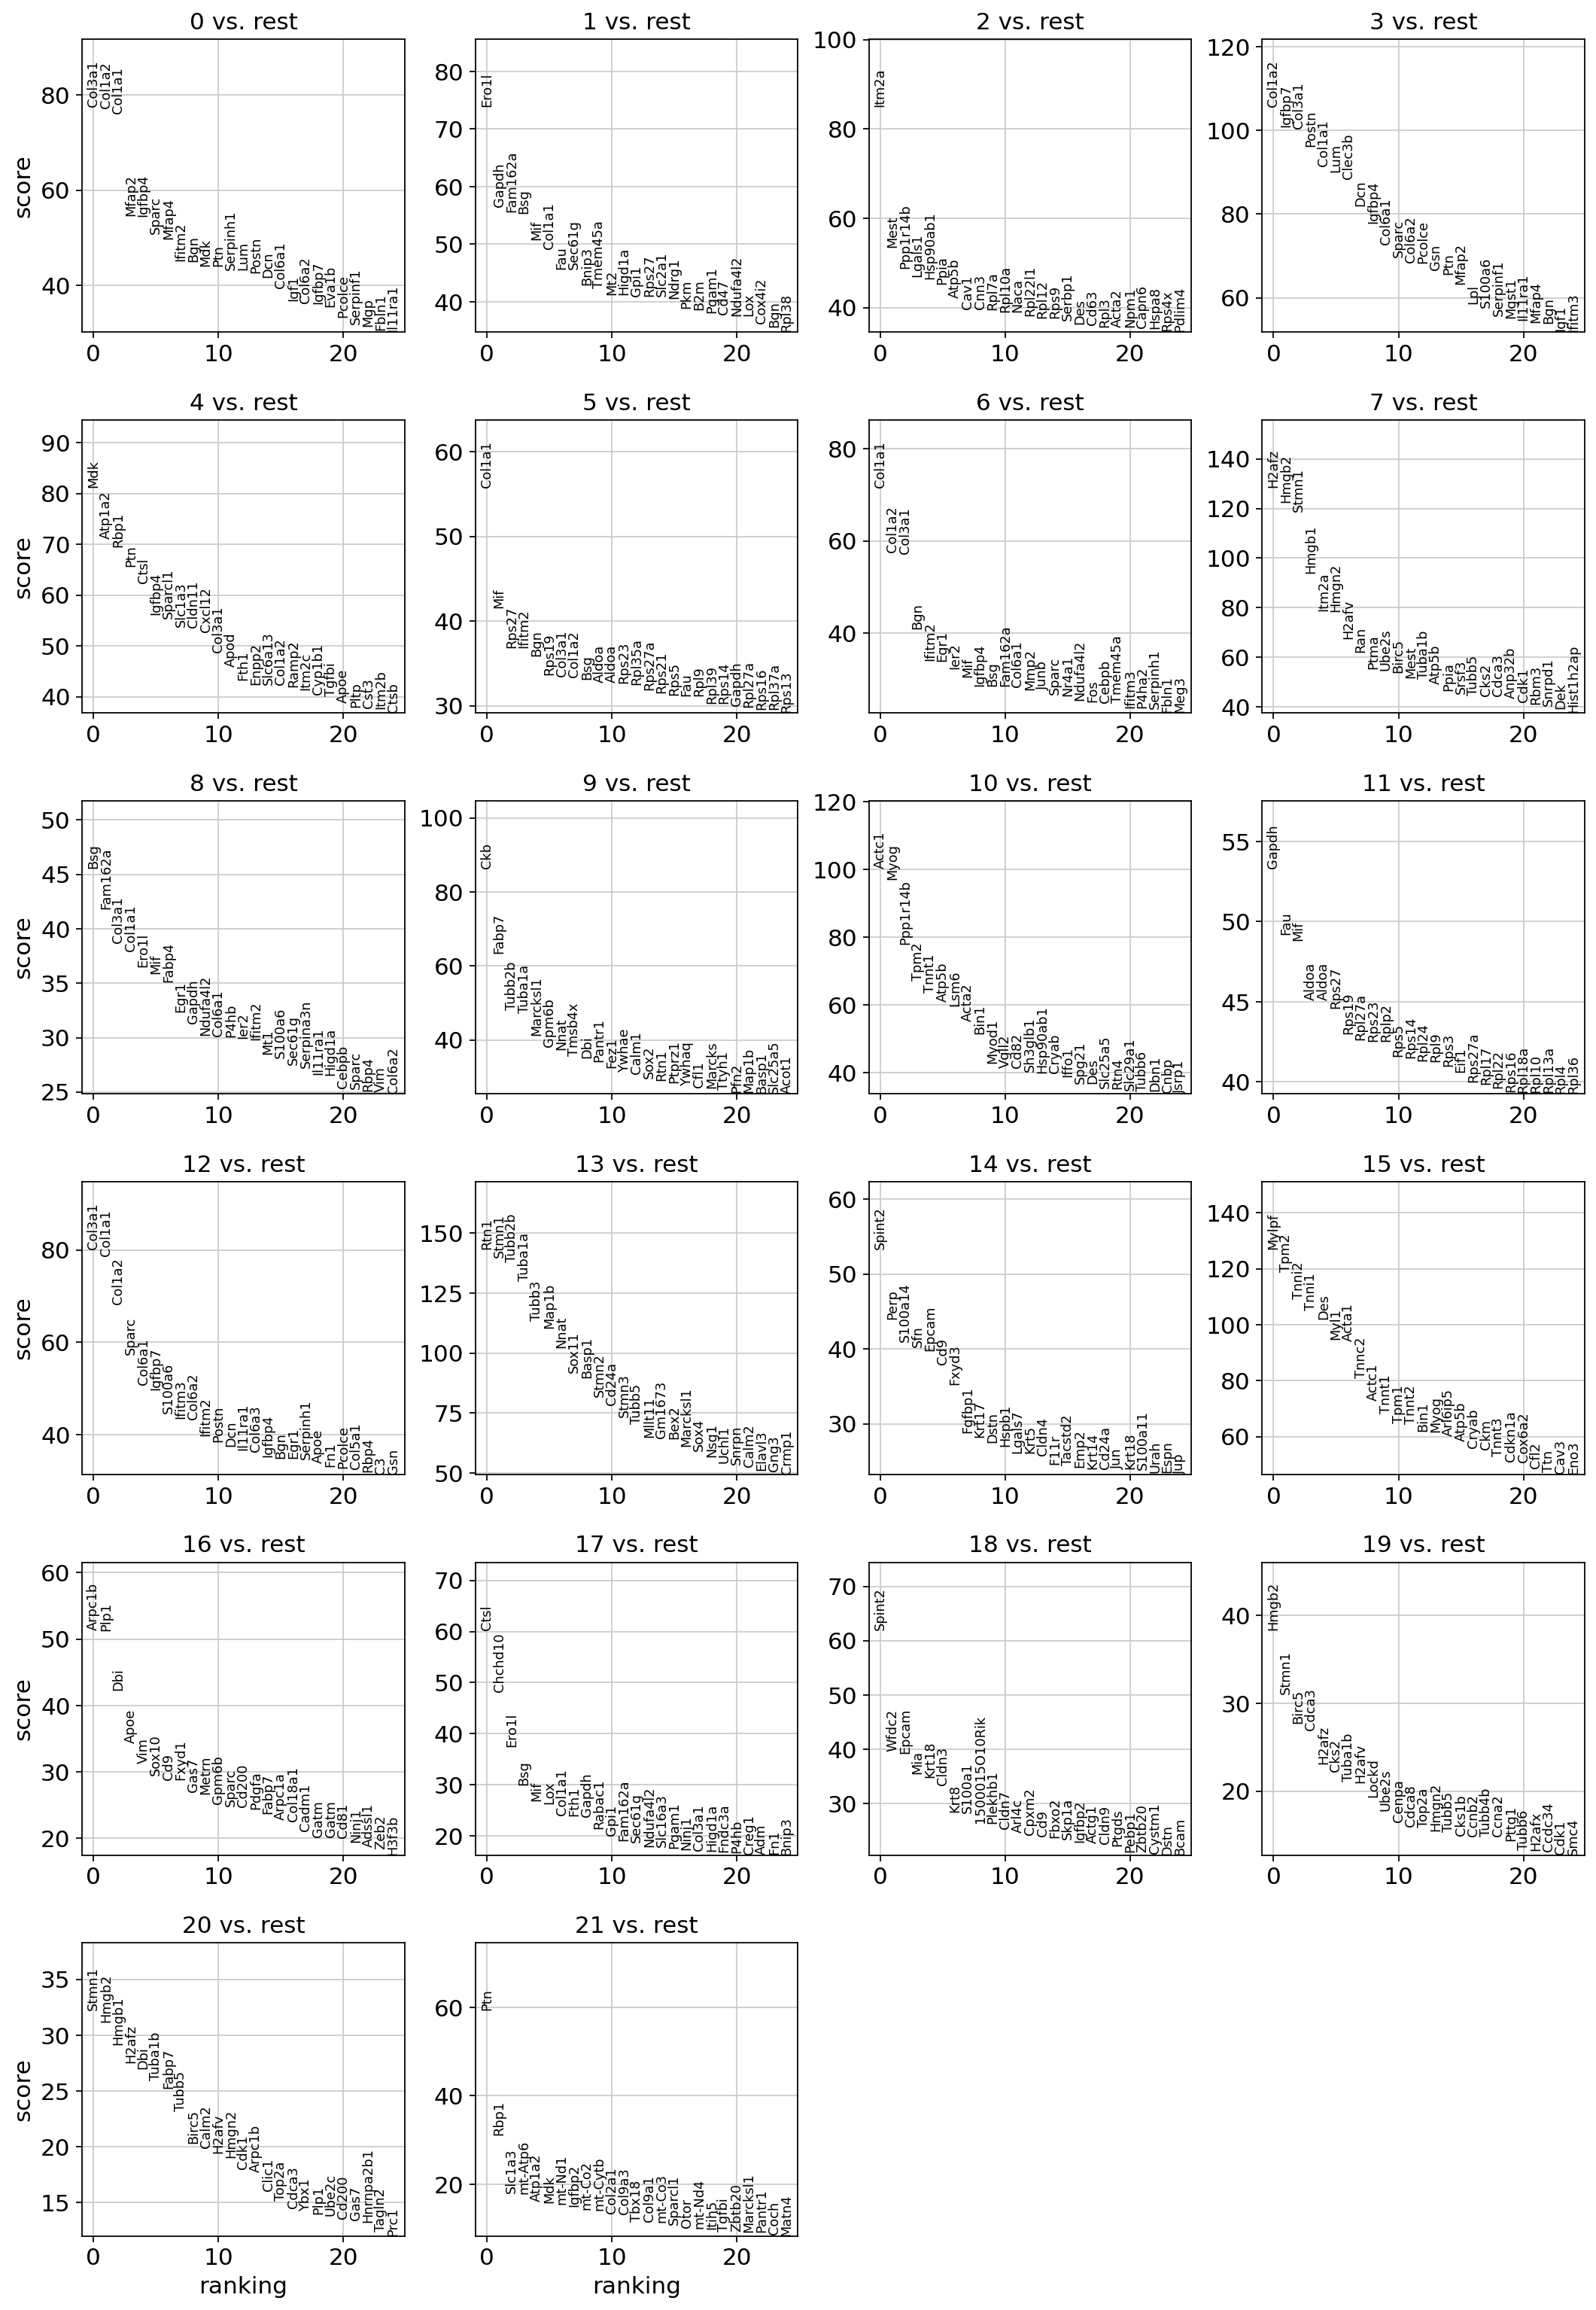

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, gene_symbols='gene_symbol', sharey=False)

In [40]:
marker_genes = ['Sox10', 'Fxyd3', 'Tubb3', 'Rbp1']
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,ENSMUSG00000026043,ENSMUSG00000021831,ENSMUSG00000031239,ENSMUSG00000029661,ENSMUSG00000027239,ENSMUSG00000001506,ENSMUSG00000001506,ENSMUSG00000037894,ENSMUSG00000023175,ENSMUSG00000001270,...,ENSMUSG00000026043,ENSMUSG00000021087,ENSMUSG00000074227,ENSMUSG00000030672,ENSMUSG00000029622,ENSMUSG00000021477,ENSMUSG00000074227,ENSMUSG00000054717,ENSMUSG00000028832,ENSMUSG00000029838
1,ENSMUSG00000029661,ENSMUSG00000057666,ENSMUSG00000051855,ENSMUSG00000036256,ENSMUSG00000007097,ENSMUSG00000033307,ENSMUSG00000029661,ENSMUSG00000054717,ENSMUSG00000003955,ENSMUSG00000019874,...,ENSMUSG00000001506,ENSMUSG00000028832,ENSMUSG00000019851,ENSMUSG00000028464,ENSMUSG00000031425,ENSMUSG00000049422,ENSMUSG00000017723,ENSMUSG00000028832,ENSMUSG00000054717,ENSMUSG00000046402
2,ENSMUSG00000001506,ENSMUSG00000003955,ENSMUSG00000056612,ENSMUSG00000026043,ENSMUSG00000046402,ENSMUSG00000090733,ENSMUSG00000026043,ENSMUSG00000028832,ENSMUSG00000026043,ENSMUSG00000045136,...,ENSMUSG00000029661,ENSMUSG00000045136,ENSMUSG00000042306,ENSMUSG00000031097,ENSMUSG00000026385,ENSMUSG00000021831,ENSMUSG00000045394,ENSMUSG00000017716,ENSMUSG00000066551,ENSMUSG00000005360
3,ENSMUSG00000060572,ENSMUSG00000023175,ENSMUSG00000068220,ENSMUSG00000027750,ENSMUSG00000029838,ENSMUSG00000060591,ENSMUSG00000031375,ENSMUSG00000066551,ENSMUSG00000001506,ENSMUSG00000072235,...,ENSMUSG00000018593,ENSMUSG00000072235,ENSMUSG00000047281,ENSMUSG00000026418,ENSMUSG00000002985,ENSMUSG00000023175,ENSMUSG00000089661,ENSMUSG00000023505,ENSMUSG00000037894,ENSMUSG00000064357
4,ENSMUSG00000017493,ENSMUSG00000033307,ENSMUSG00000023944,ENSMUSG00000001506,ENSMUSG00000021477,ENSMUSG00000031375,ENSMUSG00000060591,ENSMUSG00000031239,ENSMUSG00000021831,ENSMUSG00000047945,...,ENSMUSG00000001119,ENSMUSG00000062380,ENSMUSG00000045394,ENSMUSG00000026208,ENSMUSG00000026728,ENSMUSG00000033307,ENSMUSG00000023043,ENSMUSG00000037894,ENSMUSG00000026385,ENSMUSG00000007097


In [42]:
### compare a cluster
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8, use_raw=False)

KeyError: "Could not find keys '['ENSMUSG00000060591']' in columns of `adata.obs` or in adata.var_names."

In [37]:
sc.pl.violin(adata, marker_genes, groupby='leiden', gene_symbols='gene_symbol')


KeyError: "Could not find keys '['Fxyd3', 'Rbp1', 'Sox10', 'Tubb3']' in columns of `adata.obs` or in adata.raw.var_names."